In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

# Preparing the Datasets

In [2]:
train_df = pd.read_csv('/kaggle/input/bakery-sales-prediction-summer-2025/train.csv')
test_df = pd.read_csv('/kaggle/input/bakery-sales-prediction-summer-2025/test.csv')
weather_df = pd.read_csv('/kaggle/input/bakery-sales-prediction-summer-2025/wetter.csv')
kiwo_df = pd.read_csv('/kaggle/input/bakery-sales-prediction-summer-2025/kiwo.csv')

sample_df = pd.read_csv('/kaggle/input/bakery-sales-prediction-summer-2025/sample_submission.csv')

In [3]:
train_df = train_df.sort_values('Datum')
test_df = test_df.sort_values('Datum')

In [4]:
train_df

,id,Datum,Warengruppe,Umsatz
0,1307011,2013-07-01,1,148.828353
3638,1307013,2013-07-01,3,201.198426
7223,1307015,2013-07-01,5,317.475875
1819,1307012,2013-07-01,2,535.856285
5457,1307014,2013-07-01,4,65.890169
...,...,...,...,...
9041,1807315,2018-07-31,5,261.341313
1818,1807311,2018-07-31,1,123.075682
5456,1807313,2018-07-31,3,285.872616
3637,1807312,2018-07-31,2,586.081666


In [5]:
test_df

,id,Datum,Warengruppe
0,1808011,2018-08-01,1
710,1808013,2018-08-01,3
1065,1808014,2018-08-01,4
1419,1808015,2018-08-01,5
355,1808012,2018-08-01,2
...,...,...,...
354,1907301,2019-07-30,1
709,1907302,2019-07-30,2
1773,1907305,2019-07-30,5
1418,1907304,2019-07-30,4


In [6]:
train_df['Datum'] = pd.to_datetime(train_df['Datum'], format='mixed', dayfirst=True, errors='coerce')
test_df['Datum'] = pd.to_datetime(test_df['Datum'], format='mixed', dayfirst=True, errors='coerce')

In [7]:
train_df.isna().any()

id             False
Datum          False
Warengruppe    False
Umsatz         False
dtype: bool

In [8]:
test_df.isna().any()

id             False
Datum          False
Warengruppe    False
dtype: bool

In [9]:
train_df

,id,Datum,Warengruppe,Umsatz
0,1307011,2013-07-01,1,148.828353
3638,1307013,2013-07-01,3,201.198426
7223,1307015,2013-07-01,5,317.475875
1819,1307012,2013-07-01,2,535.856285
5457,1307014,2013-07-01,4,65.890169
...,...,...,...,...
9041,1807315,2018-07-31,5,261.341313
1818,1807311,2018-07-31,1,123.075682
5456,1807313,2018-07-31,3,285.872616
3637,1807312,2018-07-31,2,586.081666


In [10]:
test_df

,id,Datum,Warengruppe
0,1808011,2018-08-01,1
710,1808013,2018-08-01,3
1065,1808014,2018-08-01,4
1419,1808015,2018-08-01,5
355,1808012,2018-08-01,2
...,...,...,...
354,1907301,2019-07-30,1
709,1907302,2019-07-30,2
1773,1907305,2019-07-30,5
1418,1907304,2019-07-30,4


# Visualizating the Datasets

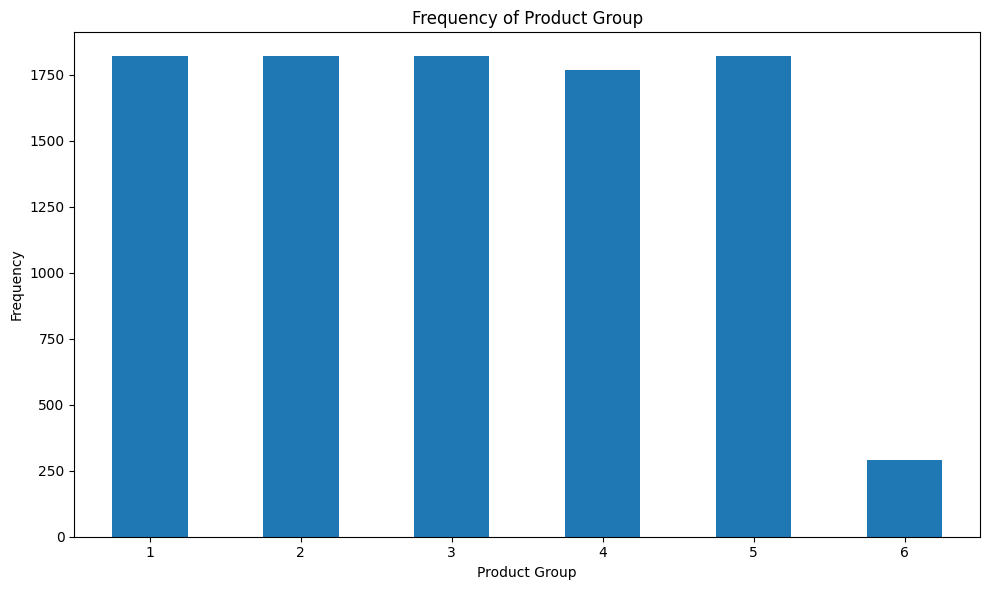

In [11]:
waren_gruppe_counts = train_df["Warengruppe"].value_counts().sort_index()
plt.figure(figsize=(10, 6))
waren_gruppe_counts.plot(kind='bar')
plt.title('Frequency of Product Group')
plt.xlabel('Product Group')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

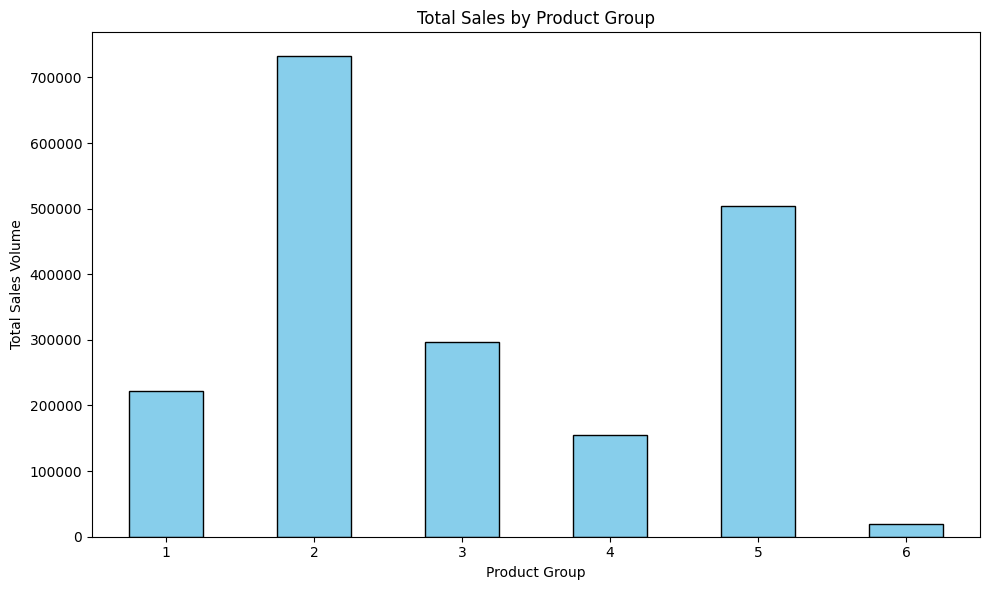

In [12]:
category_sales = train_df.groupby('Warengruppe')['Umsatz'].sum()
plt.figure(figsize=(10, 6))
category_sales.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Total Sales by Product Group')
plt.xlabel('Product Group')
plt.ylabel('Total Sales Volume')
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()

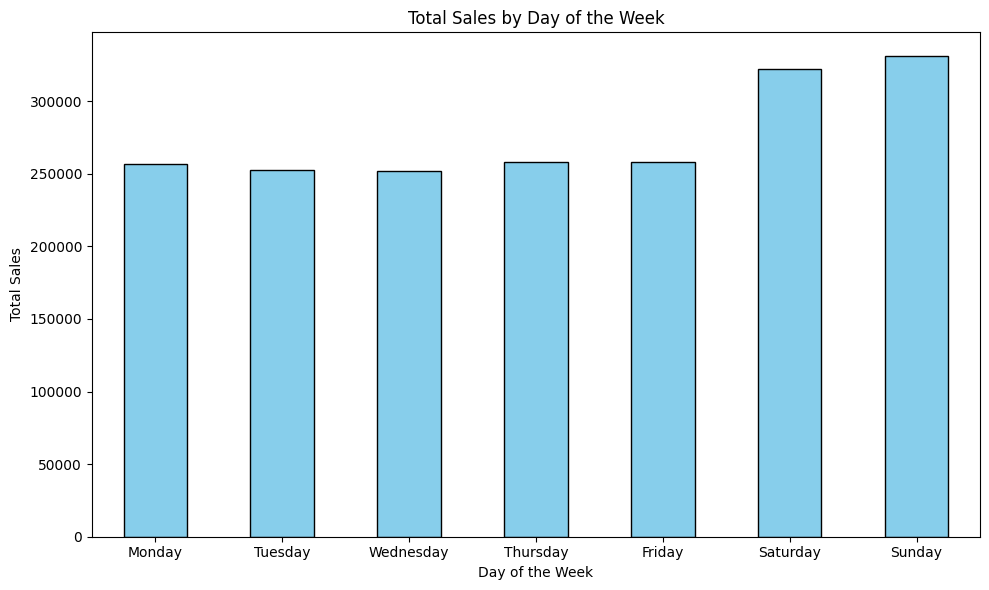

In [13]:
train_df['weekday'] = train_df['Datum'].dt.day_name()
weekday_sales = train_df.groupby('weekday')['Umsatz'].sum()
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sales = weekday_sales.reindex(ordered_days)

plt.figure(figsize=(10, 6))
weekday_sales.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Total Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()

In [14]:
kiwo_df['Datum'] = pd.to_datetime(kiwo_df['Datum'])

In [15]:
merged_df = pd.merge(train_df, kiwo_df, on='Datum', how='left')

In [16]:
merged_df['KielerWoche'] = merged_df['KielerWoche'].fillna(0)

In [17]:
merged_df = merged_df.sort_values('Datum').reset_index(drop=True)

merged_df['kw_block'] = (merged_df['KielerWoche'] != merged_df['KielerWoche'].shift(1)).cumsum()

kw_blocks = merged_df[merged_df['KielerWoche'] == 1].groupby('kw_block').agg(
    start_date=('Datum', 'min'),
    end_date=('Datum', 'max')
).reset_index(drop=True)

print(kw_blocks)

  start_date   end_date
0 2014-06-21 2014-06-29
1 2015-06-20 2015-06-28
2 2016-06-18 2016-06-26
3 2017-06-17 2017-06-25
4 2018-06-16 2018-06-24


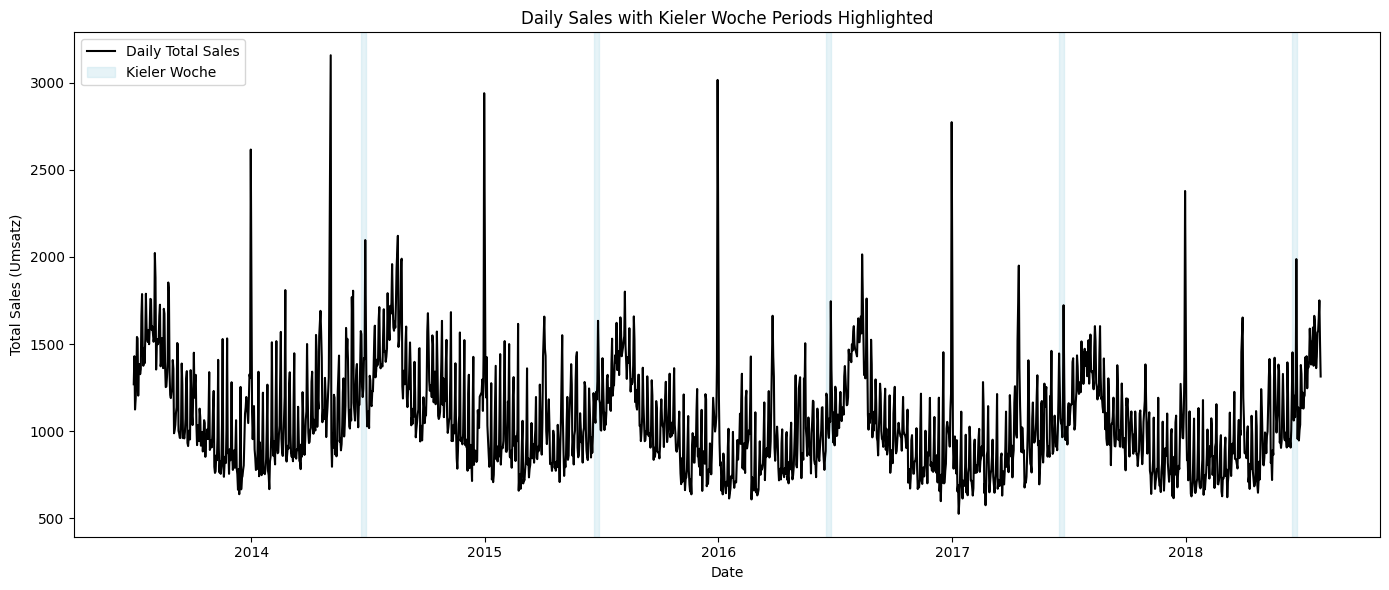

In [18]:
daily_sales = merged_df.groupby('Datum')['Umsatz'].sum().reset_index()

plt.figure(figsize=(14, 6))
plt.plot(daily_sales['Datum'], daily_sales['Umsatz'], label='Daily Total Sales', color='black')

for _, row in kw_blocks.iterrows():
    plt.axvspan(row['start_date'], row['end_date'], color='lightblue', alpha=0.3, label='Kieler Woche')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel('Date')
plt.ylabel('Total Sales (Umsatz)')
plt.title('Daily Sales with Kieler Woche Periods Highlighted')
plt.tight_layout()
plt.show()

# Feature Engineering

In [19]:
train_df

,id,Datum,Warengruppe,Umsatz,weekday
0,1307011,2013-07-01,1,148.828353,Monday
3638,1307013,2013-07-01,3,201.198426,Monday
7223,1307015,2013-07-01,5,317.475875,Monday
1819,1307012,2013-07-01,2,535.856285,Monday
5457,1307014,2013-07-01,4,65.890169,Monday
...,...,...,...,...,...
9041,1807315,2018-07-31,5,261.341313,Tuesday
1818,1807311,2018-07-31,1,123.075682,Tuesday
5456,1807313,2018-07-31,3,285.872616,Tuesday
3637,1807312,2018-07-31,2,586.081666,Tuesday


In [20]:
train_df = pd.merge(train_df, kiwo_df, on='Datum', how='left')

In [21]:
train_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Datum,Warengruppe,Umsatz,weekday,KielerWoche
0,1307011,2013-07-01,1,148.828353,Monday,NaN
1,1307013,2013-07-01,3,201.198426,Monday,NaN
2,1307015,2013-07-01,5,317.475875,Monday,NaN
3,1307012,2013-07-01,2,535.856285,Monday,NaN
4,1307014,2013-07-01,4,65.890169,Monday,NaN
...,...,...,...,...,...,...
9329,1807315,2018-07-31,5,261.341313,Tuesday,NaN
9330,1807311,2018-07-31,1,123.075682,Tuesday,NaN
9331,1807313,2018-07-31,3,285.872616,Tuesday,NaN
9332,1807312,2018-07-31,2,586.081666,Tuesday,NaN


In [22]:
train_df['KielerWoche'] = train_df['KielerWoche'].fillna(0).astype(int)

In [23]:
train_df

,id,Datum,Warengruppe,Umsatz,weekday,KielerWoche
0,1307011,2013-07-01,1,148.828353,Monday,0
1,1307013,2013-07-01,3,201.198426,Monday,0
2,1307015,2013-07-01,5,317.475875,Monday,0
3,1307012,2013-07-01,2,535.856285,Monday,0
4,1307014,2013-07-01,4,65.890169,Monday,0
...,...,...,...,...,...,...
9329,1807315,2018-07-31,5,261.341313,Tuesday,0
9330,1807311,2018-07-31,1,123.075682,Tuesday,0
9331,1807313,2018-07-31,3,285.872616,Tuesday,0
9332,1807312,2018-07-31,2,586.081666,Tuesday,0


In [24]:
train_df['KielerWoche'].value_counts()

KielerWoche
0    9111
1     223
Name: count, dtype: int64

In [25]:
train_df['weekday'] = train_df['Datum'].dt.weekday  

In [26]:
train_df

,id,Datum,Warengruppe,Umsatz,weekday,KielerWoche
0,1307011,2013-07-01,1,148.828353,0,0
1,1307013,2013-07-01,3,201.198426,0,0
2,1307015,2013-07-01,5,317.475875,0,0
3,1307012,2013-07-01,2,535.856285,0,0
4,1307014,2013-07-01,4,65.890169,0,0
...,...,...,...,...,...,...
9329,1807315,2018-07-31,5,261.341313,1,0
9330,1807311,2018-07-31,1,123.075682,1,0
9331,1807313,2018-07-31,3,285.872616,1,0
9332,1807312,2018-07-31,2,586.081666,1,0


In [27]:
train_df['month'] = train_df['Datum'].dt.month

In [28]:
train_df

,id,Datum,Warengruppe,Umsatz,weekday,KielerWoche,month
0,1307011,2013-07-01,1,148.828353,0,0,7
1,1307013,2013-07-01,3,201.198426,0,0,7
2,1307015,2013-07-01,5,317.475875,0,0,7
3,1307012,2013-07-01,2,535.856285,0,0,7
4,1307014,2013-07-01,4,65.890169,0,0,7
...,...,...,...,...,...,...,...
9329,1807315,2018-07-31,5,261.341313,1,0,7
9330,1807311,2018-07-31,1,123.075682,1,0,7
9331,1807313,2018-07-31,3,285.872616,1,0,7
9332,1807312,2018-07-31,2,586.081666,1,0,7


In [29]:
train_df['is_weekend'] = train_df['weekday'].isin([5, 6]).astype(int)

In [30]:
train_df

,id,Datum,Warengruppe,Umsatz,weekday,KielerWoche,month,is_weekend
0,1307011,2013-07-01,1,148.828353,0,0,7,0
1,1307013,2013-07-01,3,201.198426,0,0,7,0
2,1307015,2013-07-01,5,317.475875,0,0,7,0
3,1307012,2013-07-01,2,535.856285,0,0,7,0
4,1307014,2013-07-01,4,65.890169,0,0,7,0
...,...,...,...,...,...,...,...,...
9329,1807315,2018-07-31,5,261.341313,1,0,7,0
9330,1807311,2018-07-31,1,123.075682,1,0,7,0
9331,1807313,2018-07-31,3,285.872616,1,0,7,0
9332,1807312,2018-07-31,2,586.081666,1,0,7,0


In [31]:
dummies = pd.get_dummies(train_df['Warengruppe'], prefix='Warengruppe', drop_first=False).astype(int)

In [32]:
dummies

,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6
0,1,0,0,0,0,0
1,0,0,1,0,0,0
2,0,0,0,0,1,0
3,0,1,0,0,0,0
4,0,0,0,1,0,0
...,...,...,...,...,...,...
9329,0,0,0,0,1,0
9330,1,0,0,0,0,0
9331,0,0,1,0,0,0
9332,0,1,0,0,0,0


In [33]:
train_df = pd.concat([train_df.drop(columns=['Warengruppe']), dummies], axis=1)

In [34]:
train_df

,id,Datum,Umsatz,weekday,KielerWoche,month,is_weekend,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6
0,1307011,2013-07-01,148.828353,0,0,7,0,1,0,0,0,0,0
1,1307013,2013-07-01,201.198426,0,0,7,0,0,0,1,0,0,0
2,1307015,2013-07-01,317.475875,0,0,7,0,0,0,0,0,1,0
3,1307012,2013-07-01,535.856285,0,0,7,0,0,1,0,0,0,0
4,1307014,2013-07-01,65.890169,0,0,7,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,1807315,2018-07-31,261.341313,1,0,7,0,0,0,0,0,1,0
9330,1807311,2018-07-31,123.075682,1,0,7,0,1,0,0,0,0,0
9331,1807313,2018-07-31,285.872616,1,0,7,0,0,0,1,0,0,0
9332,1807312,2018-07-31,586.081666,1,0,7,0,0,1,0,0,0,0


In [35]:
train_df['weekday_sin'] = np.sin(2 * np.pi * train_df['weekday'] / 7)
train_df['weekday_cos'] = np.cos(2 * np.pi * train_df['weekday'] / 7)

In [36]:
train_df

,id,Datum,Umsatz,weekday,KielerWoche,month,is_weekend,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,weekday_sin,weekday_cos
0,1307011,2013-07-01,148.828353,0,0,7,0,1,0,0,0,0,0,0.000000,1.00000
1,1307013,2013-07-01,201.198426,0,0,7,0,0,0,1,0,0,0,0.000000,1.00000
2,1307015,2013-07-01,317.475875,0,0,7,0,0,0,0,0,1,0,0.000000,1.00000
3,1307012,2013-07-01,535.856285,0,0,7,0,0,1,0,0,0,0,0.000000,1.00000
4,1307014,2013-07-01,65.890169,0,0,7,0,0,0,0,1,0,0,0.000000,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,1807315,2018-07-31,261.341313,1,0,7,0,0,0,0,0,1,0,0.781831,0.62349
9330,1807311,2018-07-31,123.075682,1,0,7,0,1,0,0,0,0,0,0.781831,0.62349
9331,1807313,2018-07-31,285.872616,1,0,7,0,0,0,1,0,0,0,0.781831,0.62349
9332,1807312,2018-07-31,586.081666,1,0,7,0,0,1,0,0,0,0,0.781831,0.62349


In [37]:
train_df['month_sin'] = np.sin(2 * np.pi * train_df['month'] / 12)
train_df['month_cos'] = np.cos(2 * np.pi * train_df['month'] / 12)

In [38]:
train_df

,id,Datum,Umsatz,weekday,KielerWoche,month,is_weekend,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,weekday_sin,weekday_cos,month_sin,month_cos
0,1307011,2013-07-01,148.828353,0,0,7,0,1,0,0,0,0,0,0.000000,1.00000,-0.5,-0.866025
1,1307013,2013-07-01,201.198426,0,0,7,0,0,0,1,0,0,0,0.000000,1.00000,-0.5,-0.866025
2,1307015,2013-07-01,317.475875,0,0,7,0,0,0,0,0,1,0,0.000000,1.00000,-0.5,-0.866025
3,1307012,2013-07-01,535.856285,0,0,7,0,0,1,0,0,0,0,0.000000,1.00000,-0.5,-0.866025
4,1307014,2013-07-01,65.890169,0,0,7,0,0,0,0,1,0,0,0.000000,1.00000,-0.5,-0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,1807315,2018-07-31,261.341313,1,0,7,0,0,0,0,0,1,0,0.781831,0.62349,-0.5,-0.866025
9330,1807311,2018-07-31,123.075682,1,0,7,0,1,0,0,0,0,0,0.781831,0.62349,-0.5,-0.866025
9331,1807313,2018-07-31,285.872616,1,0,7,0,0,0,1,0,0,0,0.781831,0.62349,-0.5,-0.866025
9332,1807312,2018-07-31,586.081666,1,0,7,0,0,1,0,0,0,0,0.781831,0.62349,-0.5,-0.866025


In [39]:
train_df = train_df.drop(columns=['weekday', 'month'])

In [40]:
train_df

,id,Datum,Umsatz,KielerWoche,is_weekend,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,weekday_sin,weekday_cos,month_sin,month_cos
0,1307011,2013-07-01,148.828353,0,0,1,0,0,0,0,0,0.000000,1.00000,-0.5,-0.866025
1,1307013,2013-07-01,201.198426,0,0,0,0,1,0,0,0,0.000000,1.00000,-0.5,-0.866025
2,1307015,2013-07-01,317.475875,0,0,0,0,0,0,1,0,0.000000,1.00000,-0.5,-0.866025
3,1307012,2013-07-01,535.856285,0,0,0,1,0,0,0,0,0.000000,1.00000,-0.5,-0.866025
4,1307014,2013-07-01,65.890169,0,0,0,0,0,1,0,0,0.000000,1.00000,-0.5,-0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,1807315,2018-07-31,261.341313,0,0,0,0,0,0,1,0,0.781831,0.62349,-0.5,-0.866025
9330,1807311,2018-07-31,123.075682,0,0,1,0,0,0,0,0,0.781831,0.62349,-0.5,-0.866025
9331,1807313,2018-07-31,285.872616,0,0,0,0,1,0,0,0,0.781831,0.62349,-0.5,-0.866025
9332,1807312,2018-07-31,586.081666,0,0,0,1,0,0,0,0,0.781831,0.62349,-0.5,-0.866025


# Splitting the Datasets 

In [41]:
# Split Training set from 01.07.2013 to 31.07.2017
training_start_date = '2013-07-01'
training_end_date = '2017-07-31'
# Split Validation set from 01.08.2017 to 31.07.2018
validation_start_date = '2017-08-01'
validation_end_date = '2018-07-31'

In [42]:
df_train_split = train_df[(train_df['Datum'] >= training_start_date) & (train_df['Datum'] <= training_end_date)].copy()

In [43]:
df_train_split

,id,Datum,Umsatz,KielerWoche,is_weekend,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,weekday_sin,weekday_cos,month_sin,month_cos
0,1307011,2013-07-01,148.828353,0,0,1,0,0,0,0,0,0.0,1.0,-0.5,-0.866025
1,1307013,2013-07-01,201.198426,0,0,0,0,1,0,0,0,0.0,1.0,-0.5,-0.866025
2,1307015,2013-07-01,317.475875,0,0,0,0,0,0,1,0,0.0,1.0,-0.5,-0.866025
3,1307012,2013-07-01,535.856285,0,0,0,1,0,0,0,0,0.0,1.0,-0.5,-0.866025
4,1307014,2013-07-01,65.890169,0,0,0,0,0,1,0,0,0.0,1.0,-0.5,-0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7488,1707311,2017-07-31,162.425333,0,0,1,0,0,0,0,0,0.0,1.0,-0.5,-0.866025
7489,1707313,2017-07-31,294.721801,0,0,0,0,1,0,0,0,0.0,1.0,-0.5,-0.866025
7490,1707315,2017-07-31,222.684256,0,0,0,0,0,0,1,0,0.0,1.0,-0.5,-0.866025
7491,1707312,2017-07-31,548.102447,0,0,0,1,0,0,0,0,0.0,1.0,-0.5,-0.866025


In [44]:
df_validation_split = train_df[(train_df['Datum'] >= validation_start_date) & (train_df['Datum'] <= validation_end_date)].copy()

In [45]:
df_validation_split

,id,Datum,Umsatz,KielerWoche,is_weekend,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,weekday_sin,weekday_cos,month_sin,month_cos
7493,1708013,2017-08-01,294.872701,0,0,0,0,1,0,0,0,0.781831,0.62349,-0.866025,-0.500000
7494,1708012,2017-08-01,557.470898,0,0,0,1,0,0,0,0,0.781831,0.62349,-0.866025,-0.500000
7495,1708011,2017-08-01,166.135486,0,0,1,0,0,0,0,0,0.781831,0.62349,-0.866025,-0.500000
7496,1708014,2017-08-01,88.208006,0,0,0,0,0,1,0,0,0.781831,0.62349,-0.866025,-0.500000
7497,1708015,2017-08-01,325.864228,0,0,0,0,0,0,1,0,0.781831,0.62349,-0.866025,-0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,1807315,2018-07-31,261.341313,0,0,0,0,0,0,1,0,0.781831,0.62349,-0.500000,-0.866025
9330,1807311,2018-07-31,123.075682,0,0,1,0,0,0,0,0,0.781831,0.62349,-0.500000,-0.866025
9331,1807313,2018-07-31,285.872616,0,0,0,0,1,0,0,0,0.781831,0.62349,-0.500000,-0.866025
9332,1807312,2018-07-31,586.081666,0,0,0,1,0,0,0,0,0.781831,0.62349,-0.500000,-0.866025


In [46]:
X_train = df_train_split.drop(columns=['id', 'Datum', 'Umsatz'])

In [47]:
X_train

,KielerWoche,is_weekend,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,weekday_sin,weekday_cos,month_sin,month_cos
0,0,0,1,0,0,0,0,0,0.0,1.0,-0.5,-0.866025
1,0,0,0,0,1,0,0,0,0.0,1.0,-0.5,-0.866025
2,0,0,0,0,0,0,1,0,0.0,1.0,-0.5,-0.866025
3,0,0,0,1,0,0,0,0,0.0,1.0,-0.5,-0.866025
4,0,0,0,0,0,1,0,0,0.0,1.0,-0.5,-0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...
7488,0,0,1,0,0,0,0,0,0.0,1.0,-0.5,-0.866025
7489,0,0,0,0,1,0,0,0,0.0,1.0,-0.5,-0.866025
7490,0,0,0,0,0,0,1,0,0.0,1.0,-0.5,-0.866025
7491,0,0,0,1,0,0,0,0,0.0,1.0,-0.5,-0.866025


In [48]:
Y_train = df_train_split['Umsatz']

In [49]:
Y_train

0       148.828353
1       201.198426
2       317.475875
3       535.856285
4        65.890169
           ...    
7488    162.425333
7489    294.721801
7490    222.684256
7491    548.102447
7492     87.226479
Name: Umsatz, Length: 7493, dtype: float64

# Base Modeling for the Datasets

In [50]:
model = LinearRegression()

In [51]:
model.fit(X_train, Y_train)

LinearRegression()

In [52]:
coefficients = pd.Series(model.coef_, index=X_train.columns)
most_influential = coefficients.abs().sort_values(ascending=False)
print(most_influential)

Warengruppe_2    7.206451e+14
Warengruppe_5    7.206451e+14
Warengruppe_3    7.206451e+14
Warengruppe_1    7.206451e+14
Warengruppe_6    7.206451e+14
Warengruppe_4    7.206451e+14
is_weekend       4.554832e+01
month_cos        3.322398e+01
month_sin        2.751208e+01
weekday_sin      5.984342e+00
KielerWoche      4.724700e+00
weekday_cos      1.934345e-01
dtype: float64


In [53]:
X_val = df_validation_split.drop(columns=['id', 'Datum', 'Umsatz'])

In [54]:
X_val

,KielerWoche,is_weekend,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,weekday_sin,weekday_cos,month_sin,month_cos
7493,0,0,0,0,1,0,0,0,0.781831,0.62349,-0.866025,-0.500000
7494,0,0,0,1,0,0,0,0,0.781831,0.62349,-0.866025,-0.500000
7495,0,0,1,0,0,0,0,0,0.781831,0.62349,-0.866025,-0.500000
7496,0,0,0,0,0,1,0,0,0.781831,0.62349,-0.866025,-0.500000
7497,0,0,0,0,0,0,1,0,0.781831,0.62349,-0.866025,-0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
9329,0,0,0,0,0,0,1,0,0.781831,0.62349,-0.500000,-0.866025
9330,0,0,1,0,0,0,0,0,0.781831,0.62349,-0.500000,-0.866025
9331,0,0,0,0,1,0,0,0,0.781831,0.62349,-0.500000,-0.866025
9332,0,0,0,1,0,0,0,0,0.781831,0.62349,-0.500000,-0.866025


In [55]:
Y_val = df_validation_split['Umsatz']

In [56]:
Y_val

7493    294.872701
7494    557.470898
7495    166.135486
7496     88.208006
7497    325.864228
           ...    
9329    261.341313
9330    123.075682
9331    285.872616
9332    586.081666
9333     57.102795
Name: Umsatz, Length: 1841, dtype: float64

In [57]:
Y_pred_val = model.predict(X_val)

In [58]:
mape = mean_absolute_percentage_error(Y_val, Y_pred_val)

print(f"Validation MAPE: {mape:.2f}")

Validation MAPE: 0.33


In [59]:
test_df

,id,Datum,Warengruppe
0,1808011,2018-08-01,1
710,1808013,2018-08-01,3
1065,1808014,2018-08-01,4
1419,1808015,2018-08-01,5
355,1808012,2018-08-01,2
...,...,...,...
354,1907301,2019-07-30,1
709,1907302,2019-07-30,2
1773,1907305,2019-07-30,5
1418,1907304,2019-07-30,4


In [60]:
test_df['weekday'] = test_df['Datum'].dt.day_name()

In [61]:
test_df

,id,Datum,Warengruppe,weekday
0,1808011,2018-08-01,1,Wednesday
710,1808013,2018-08-01,3,Wednesday
1065,1808014,2018-08-01,4,Wednesday
1419,1808015,2018-08-01,5,Wednesday
355,1808012,2018-08-01,2,Wednesday
...,...,...,...,...
354,1907301,2019-07-30,1,Tuesday
709,1907302,2019-07-30,2,Tuesday
1773,1907305,2019-07-30,5,Tuesday
1418,1907304,2019-07-30,4,Tuesday


In [62]:
test_df['weekday'] = test_df['Datum'].dt.weekday  

In [63]:
test_df['is_weekend'] = test_df['weekday'].isin([5, 6]).astype(int)

In [64]:
test_df['Datum'] = pd.to_datetime(test_df['Datum'])

In [65]:
merged_df = pd.merge(test_df, kiwo_df, on='Datum', how='left')

In [66]:
merged_df['KielerWoche'] = merged_df['KielerWoche'].fillna(0)

In [67]:
merged_df = merged_df.sort_values('Datum').reset_index(drop=True)

In [68]:
test_df['weekday'] = test_df['Datum'].dt.weekday
test_df['month'] = test_df['Datum'].dt.month

In [69]:
test_df['weekday_sin'] = np.sin(2 * np.pi * test_df['weekday'] / 7)
test_df['weekday_cos'] = np.cos(2 * np.pi * test_df['weekday'] / 7)

In [70]:
test_df['month_sin'] = np.sin(2 * np.pi * test_df['month'] / 12)
test_df['month_cos'] = np.cos(2 * np.pi * test_df['month'] / 12)

In [71]:
test_df

,id,Datum,Warengruppe,weekday,is_weekend,month,weekday_sin,weekday_cos,month_sin,month_cos
0,1808011,2018-08-01,1,2,0,8,0.974928,-0.222521,-0.866025,-0.500000
710,1808013,2018-08-01,3,2,0,8,0.974928,-0.222521,-0.866025,-0.500000
1065,1808014,2018-08-01,4,2,0,8,0.974928,-0.222521,-0.866025,-0.500000
1419,1808015,2018-08-01,5,2,0,8,0.974928,-0.222521,-0.866025,-0.500000
355,1808012,2018-08-01,2,2,0,8,0.974928,-0.222521,-0.866025,-0.500000
...,...,...,...,...,...,...,...,...,...,...
354,1907301,2019-07-30,1,1,0,7,0.781831,0.623490,-0.500000,-0.866025
709,1907302,2019-07-30,2,1,0,7,0.781831,0.623490,-0.500000,-0.866025
1773,1907305,2019-07-30,5,1,0,7,0.781831,0.623490,-0.500000,-0.866025
1418,1907304,2019-07-30,4,1,0,7,0.781831,0.623490,-0.500000,-0.866025


In [72]:
warengruppe_dummies = pd.get_dummies(test_df['Warengruppe'], prefix='Warengruppe', drop_first=False).astype(int)

In [73]:
test_df = pd.concat([test_df.drop(columns=['Warengruppe', 'weekday', 'month']), warengruppe_dummies], axis=1)

In [74]:
test_df

,id,Datum,is_weekend,weekday_sin,weekday_cos,month_sin,month_cos,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6
0,1808011,2018-08-01,0,0.974928,-0.222521,-0.866025,-0.500000,1,0,0,0,0,0
710,1808013,2018-08-01,0,0.974928,-0.222521,-0.866025,-0.500000,0,0,1,0,0,0
1065,1808014,2018-08-01,0,0.974928,-0.222521,-0.866025,-0.500000,0,0,0,1,0,0
1419,1808015,2018-08-01,0,0.974928,-0.222521,-0.866025,-0.500000,0,0,0,0,1,0
355,1808012,2018-08-01,0,0.974928,-0.222521,-0.866025,-0.500000,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,1907301,2019-07-30,0,0.781831,0.623490,-0.500000,-0.866025,1,0,0,0,0,0
709,1907302,2019-07-30,0,0.781831,0.623490,-0.500000,-0.866025,0,1,0,0,0,0
1773,1907305,2019-07-30,0,0.781831,0.623490,-0.500000,-0.866025,0,0,0,0,1,0
1418,1907304,2019-07-30,0,0.781831,0.623490,-0.500000,-0.866025,0,0,0,1,0,0


In [75]:
test_df = pd.merge(test_df, kiwo_df, on='Datum', how='left')

In [76]:
test_df['KielerWoche'] = test_df['KielerWoche'].fillna(0).astype(int)

In [77]:
test_df

,id,Datum,is_weekend,weekday_sin,weekday_cos,month_sin,month_cos,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,KielerWoche
0,1808011,2018-08-01,0,0.974928,-0.222521,-0.866025,-0.500000,1,0,0,0,0,0,0
1,1808013,2018-08-01,0,0.974928,-0.222521,-0.866025,-0.500000,0,0,1,0,0,0,0
2,1808014,2018-08-01,0,0.974928,-0.222521,-0.866025,-0.500000,0,0,0,1,0,0,0
3,1808015,2018-08-01,0,0.974928,-0.222521,-0.866025,-0.500000,0,0,0,0,1,0,0
4,1808012,2018-08-01,0,0.974928,-0.222521,-0.866025,-0.500000,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,1907301,2019-07-30,0,0.781831,0.623490,-0.500000,-0.866025,1,0,0,0,0,0,0
1826,1907302,2019-07-30,0,0.781831,0.623490,-0.500000,-0.866025,0,1,0,0,0,0,0
1827,1907305,2019-07-30,0,0.781831,0.623490,-0.500000,-0.866025,0,0,0,0,1,0,0
1828,1907304,2019-07-30,0,0.781831,0.623490,-0.500000,-0.866025,0,0,0,1,0,0,0


In [78]:
test_df.isna().any()

id               False
Datum            False
is_weekend       False
weekday_sin      False
weekday_cos      False
month_sin        False
month_cos        False
Warengruppe_1    False
Warengruppe_2    False
Warengruppe_3    False
Warengruppe_4    False
Warengruppe_5    False
Warengruppe_6    False
KielerWoche      False
dtype: bool

In [79]:
test_df = test_df.drop(columns=['id', 'Datum'])

In [80]:
test_df

,is_weekend,weekday_sin,weekday_cos,month_sin,month_cos,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,KielerWoche
0,0,0.974928,-0.222521,-0.866025,-0.500000,1,0,0,0,0,0,0
1,0,0.974928,-0.222521,-0.866025,-0.500000,0,0,1,0,0,0,0
2,0,0.974928,-0.222521,-0.866025,-0.500000,0,0,0,1,0,0,0
3,0,0.974928,-0.222521,-0.866025,-0.500000,0,0,0,0,1,0,0
4,0,0.974928,-0.222521,-0.866025,-0.500000,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1825,0,0.781831,0.623490,-0.500000,-0.866025,1,0,0,0,0,0,0
1826,0,0.781831,0.623490,-0.500000,-0.866025,0,1,0,0,0,0,0
1827,0,0.781831,0.623490,-0.500000,-0.866025,0,0,0,0,1,0,0
1828,0,0.781831,0.623490,-0.500000,-0.866025,0,0,0,1,0,0,0


In [81]:
desired_order = [
    'KielerWoche', 'is_weekend',
    'Warengruppe_1', 'Warengruppe_2', 'Warengruppe_3', 'Warengruppe_4', 'Warengruppe_5', 'Warengruppe_6',
    'weekday_sin', 'weekday_cos',
    'month_sin', 'month_cos'
]

test_df = test_df.reindex(columns=desired_order, fill_value=0)

In [82]:
test_df

,KielerWoche,is_weekend,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,weekday_sin,weekday_cos,month_sin,month_cos
0,0,0,1,0,0,0,0,0,0.974928,-0.222521,-0.866025,-0.500000
1,0,0,0,0,1,0,0,0,0.974928,-0.222521,-0.866025,-0.500000
2,0,0,0,0,0,1,0,0,0.974928,-0.222521,-0.866025,-0.500000
3,0,0,0,0,0,0,1,0,0.974928,-0.222521,-0.866025,-0.500000
4,0,0,0,1,0,0,0,0,0.974928,-0.222521,-0.866025,-0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
1825,0,0,1,0,0,0,0,0,0.781831,0.623490,-0.500000,-0.866025
1826,0,0,0,1,0,0,0,0,0.781831,0.623490,-0.500000,-0.866025
1827,0,0,0,0,0,0,1,0,0.781831,0.623490,-0.500000,-0.866025
1828,0,0,0,0,0,1,0,0,0.781831,0.623490,-0.500000,-0.866025


In [83]:
test_predictions = model.predict(test_df)

In [84]:
# added predicted umsatz column
test_df['umsatz'] = test_predictions

In [85]:
test_df

,KielerWoche,is_weekend,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,weekday_sin,weekday_cos,month_sin,month_cos,umsatz
0,0,0,1,0,0,0,0,0,0.974928,-0.222521,-0.866025,-0.500000,141.000
1,0,0,0,0,1,0,0,0,0.974928,-0.222521,-0.866025,-0.500000,185.000
2,0,0,0,0,0,1,0,0,0.974928,-0.222521,-0.866025,-0.500000,107.375
3,0,0,0,0,0,0,1,0,0.974928,-0.222521,-0.866025,-0.500000,301.875
4,0,0,0,1,0,0,0,0,0.974928,-0.222521,-0.866025,-0.500000,431.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,0,0,1,0,0,0,0,0,0.781831,0.623490,-0.500000,-0.866025,144.125
1826,0,0,0,1,0,0,0,0,0.781831,0.623490,-0.500000,-0.866025,434.625
1827,0,0,0,0,0,0,1,0,0.781831,0.623490,-0.500000,-0.866025,305.000
1828,0,0,0,0,0,1,0,0,0.781831,0.623490,-0.500000,-0.866025,110.500
